# Generalization

## Setup device and load Google Drive data

In [15]:
import torch
from google.colab import drive

drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


## Load data

Podział klas:
benign_malignant
benign       5647
malignant    4003
Name: count, dtype: int64


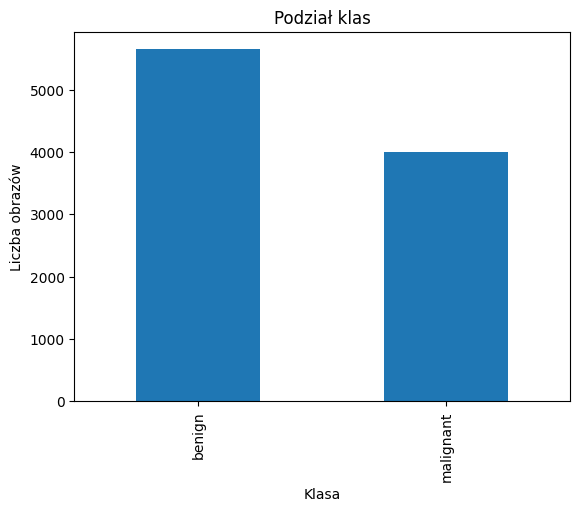

benign_malignant
benign       51
malignant    49
Name: count, dtype: int64


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/Praca magisterska/Dane/BCN20000/bcn20000_metadata_2025-05-15.csv')

df = df.dropna(subset=['benign_malignant'])

print("Podział klas:")
print(df['benign_malignant'].value_counts())

df['benign_malignant'].value_counts().plot(kind='bar', title='Podział klas')
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')
plt.show()

df = df.sample(n=100, random_state=42).reset_index(drop=True)
print(df['benign_malignant'].value_counts())

## BCN dataset loader

In [22]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class BCNDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'benign': 0, 'malignant': 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['isic_id']
        label = self.label_map[row['benign_malignant']]
        image_path = os.path.join(self.img_dir, f"{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

BATCH_SIZE = 32
IMG_DIR = '/content/drive/MyDrive/Praca magisterska/Dane/BCN20000/img'
dataset = BCNDataset(df, IMG_DIR, transform)
data_loader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

## Load models

In [23]:
def load_model(path):
    model = torch.load(path, map_location=device, weights_only=False)
    model.to(device)
    model.eval()
    return model

alexnet = load_model('/content/drive/MyDrive/Praca magisterska/Modele/alexnet.pt')
alexnet_aug = load_model('/content/drive/MyDrive/Praca magisterska/Modele/augmented_alexnet.pt')
resnet = load_model('/content/drive/MyDrive/Praca magisterska/Modele/resnet.pt')
resnet_aug = load_model('/content/drive/MyDrive/Praca magisterska/Modele/augmented_resnet.pt')
densenet = load_model('/content/drive/MyDrive/Praca magisterska/Modele/densenet.pt')
densenet_aug = load_model('/content/drive/MyDrive/Praca magisterska/Modele/augmented_densenet.pt')

## Evaluate

In [24]:
import numpy as np

def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:,1]
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

### AlexNet

In [25]:
labels_alexnet, preds_alexnet, probs_alexnet = evaluate_model(alexnet, data_loader)
labels_augalexnet, preds_augalexnet, probs_augalexnet = evaluate_model(alexnet_aug, data_loader)

### ResNet

In [26]:
labels_resnet, preds_resnet, probs_resnet = evaluate_model(resnet, data_loader)
labels_augresnet, preds_augresnet, probs_augresnet = evaluate_model(resnet_aug, data_loader)

### DenseNet

In [27]:
labels_densenet, preds_densenet, probs_densenet = evaluate_model(densenet, data_loader)
labels_augdensenet, preds_augdensenet, probs_augdensenet = evaluate_model(densenet_aug, data_loader)

## Results

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def print_metrics(labels, preds, probs, model_name="Model"):
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    auc = roc_auc_score(labels, probs)

    # Metrics
    print(f"Rezultaty dla {model_name}")
    print(f"Dokładność: {acc:.4f}")
    print(f"Precyzja: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

### DenseNet

Rezultaty dla ResNet
Dokładność: 0.5400
Precyzja: 0.5158
Recall: 1.0000
F1 Score: 0.6806
AUC: 0.6717



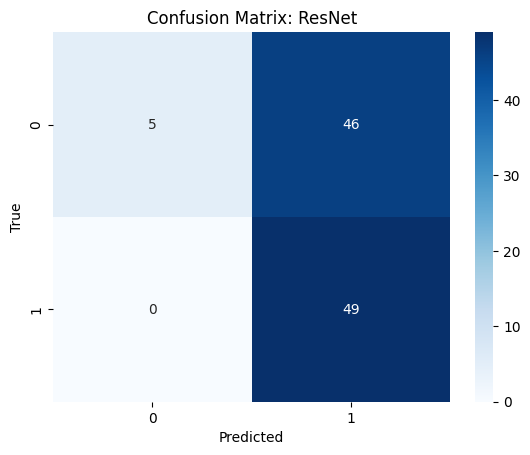

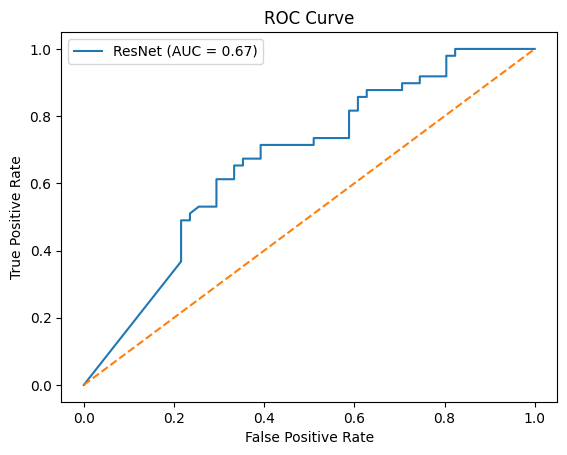

Rezultaty dla Augmented ResNet
Dokładność: 0.5800
Precyzja: 0.5432
Recall: 0.8980
F1 Score: 0.6769
AUC: 0.7223



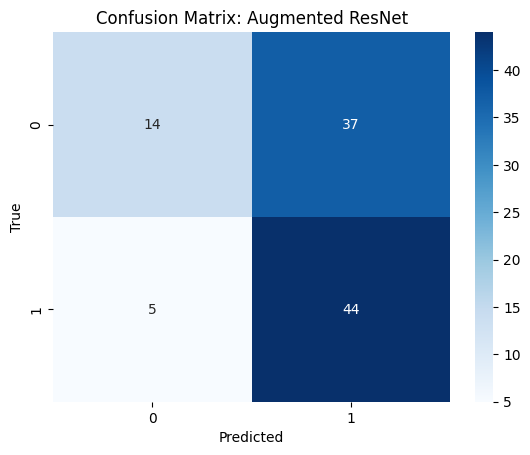

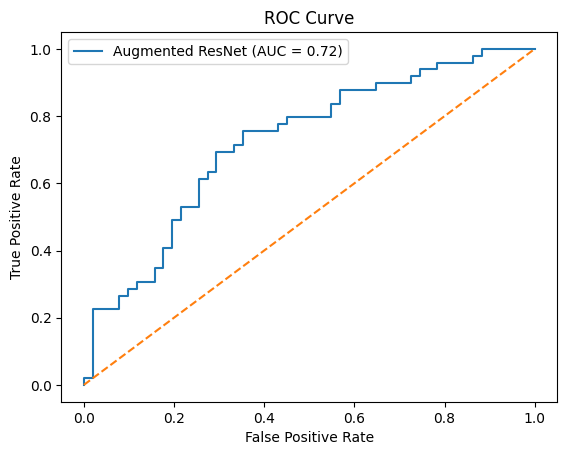

In [29]:
print_metrics(labels_resnet, preds_resnet, probs_resnet, model_name="ResNet")
print_metrics(labels_augresnet, preds_augresnet, probs_augresnet, model_name="Augmented ResNet")

### AlexNet

Rezultaty dla AlexNet
Dokładność: 0.5000
Precyzja: 0.4949
Recall: 1.0000
F1 Score: 0.6622
AUC: 0.6767



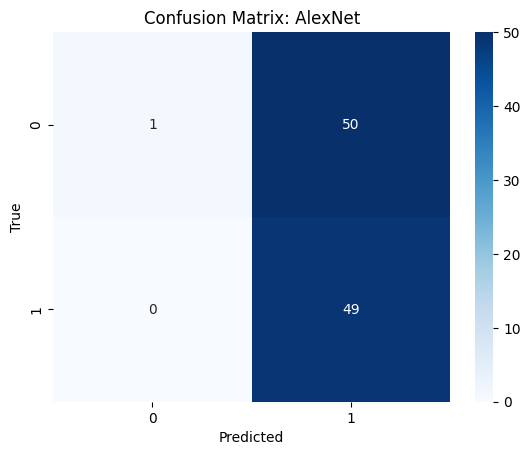

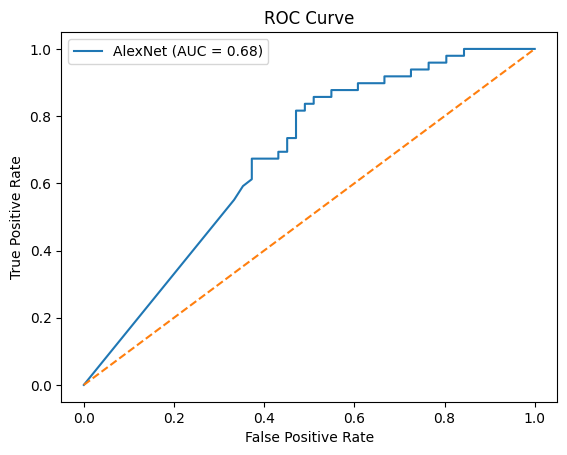

Rezultaty dla Augmented AlexNet
Dokładność: 0.5900
Precyzja: 0.5714
Recall: 0.6531
F1 Score: 0.6095
AUC: 0.6283



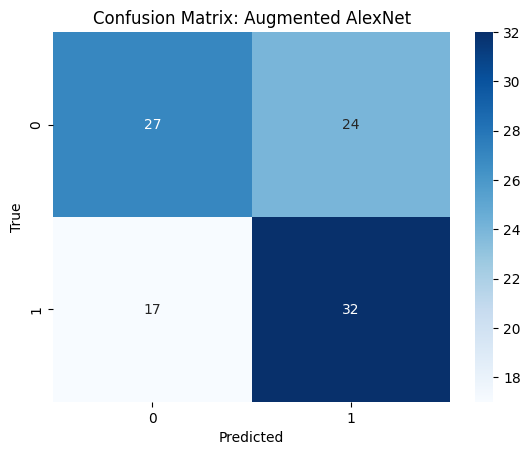

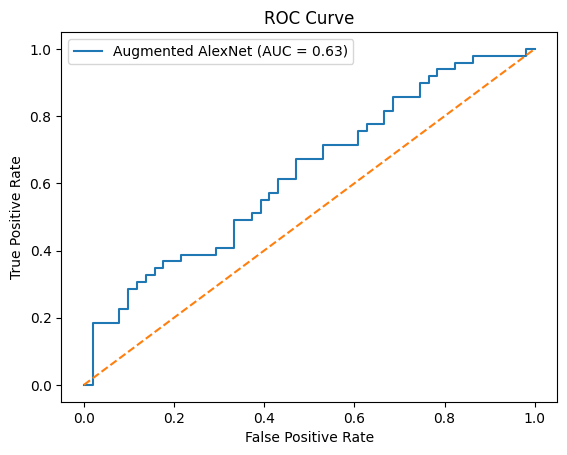

In [30]:
print_metrics(labels_alexnet, preds_alexnet, probs_alexnet, model_name="AlexNet")
print_metrics(labels_augalexnet, preds_augalexnet, probs_augalexnet, model_name="Augmented AlexNet")

### DenseNet

Rezultaty dla DenseNet
Dokładność: 0.5000
Precyzja: 0.4949
Recall: 1.0000
F1 Score: 0.6622
AUC: 0.7023



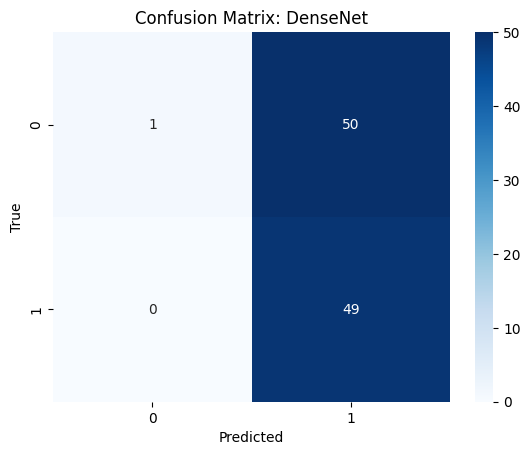

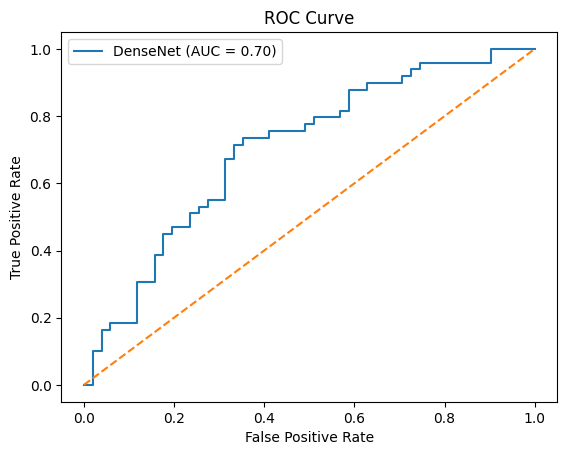

Rezultaty dla Augmented DenseNet
Dokładność: 0.5800
Precyzja: 0.5507
Recall: 0.7755
F1 Score: 0.6441
AUC: 0.6623



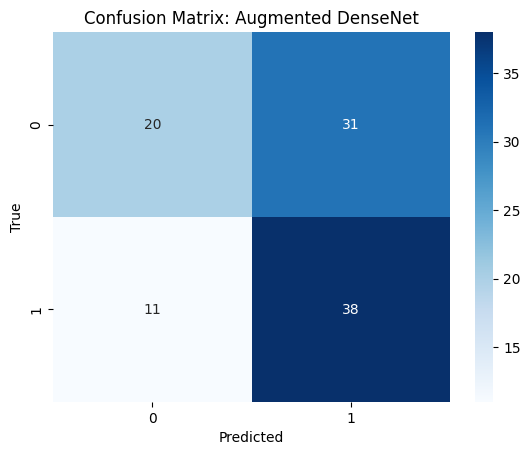

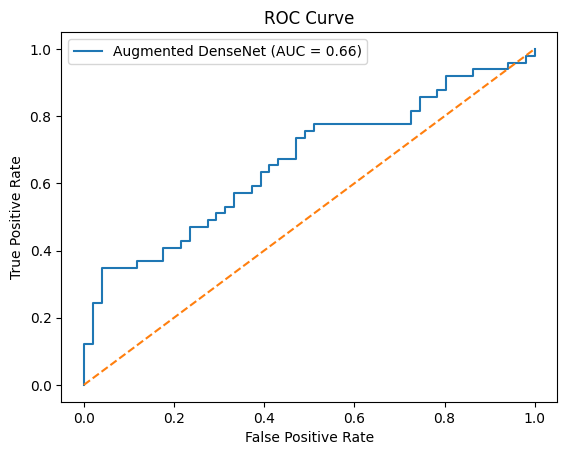

In [31]:
print_metrics(labels_densenet, preds_densenet, probs_densenet, model_name="DenseNet")
print_metrics(labels_augdensenet, preds_augdensenet, probs_augdensenet, model_name="Augmented DenseNet")